In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
# import matplotlib;matplotlib.rcParams['text.usetex'] = True
# import matplotlib;matplotlib.rcParams['font.size'] = 16
# import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
import GPy
import math
import scipy as sp
import numpy as np
import climin
import pylab as pb
from matplotlib import pyplot as plt
np.random.seed(1)

In [2]:
import pandas as pd
data = pd.read_csv("../data/2014-2017.csv")
data["Date"] = pd.to_datetime(data["Date"])

In [10]:
crime_list = data.groupby('Primary Type').count()["ID"].sort_values(ascending=False).reset_index()
districts = list(set(data.dropna(subset = ['District'])["District"]))

In [20]:
def process_multitask(lis):
    data = np.empty((0,2))
    for i in range(len(lis)):
        label = np.ones_like(lis[i])*i
        data = np.append(data, np.concatenate((lis[i],label.astype(int)), axis =1), axis=0)
    return(data)

In [30]:
class timeseries():
    def __init__(self, data):
        self.data=data
        
    def sample(self, pct):
        k = np.ceil(self.X.shape[0]*pct).astype(int)
        self.known_indices = np.random.permutation(range(self.X.shape[0]))[:k]
        self.known_X = self.X[self.known_indices]
        self.known_Y = self.Y[self.known_indices]
        
    def weekly(self, k_tasks):
        self.trainx = []
        self.trainy = []
        self.testx = []
        self.testy = []
        tasks = []
        for i in range(k_tasks):
            district = districts[i]
            tasks.append(district)
            cdata = self.data[self.data['District']==district]
            yearsince = cdata["Date"].dt.year-min(cdata["Date"].dt.year)
            cdata["week"] = cdata["Date"].dt.week+52*yearsince
            weekly_data = cdata.groupby(["week"]).count()["ID"].reset_index()

            train_set = weekly_data[weekly_data["week"]<=150]
            test_test = weekly_data[weekly_data["week"]>150]
            
            X = train_set[["week"]].values
            X = X.reshape((len(X),1)).astype(float)
            Y = train_set["ID"].values
            Y = Y.reshape((len(Y),1))
            self.trainx.append(X)
            self.trainy.append(Y)

            Xt = test_test[["week"]].values
            Xt = Xt.reshape((len(Xt),1)).astype(float)
            Yt = test_test["ID"].values
            Yt = Yt.reshape((len(Yt),1))
            self.testx.append(Xt)
            self.testy.append(Yt)
    
    def monthly(self, k_tasks):
        self.trainx = []
        self.trainy = []
        self.testx = []
        self.testy = []

        tasks = []
        for i in range(k_tasks):
            district = districts[i]
            tasks.append(district)
            cdata = self.data[self.data['District']==district]
            yearsince = cdata["Date"].dt.year-min(cdata["Date"].dt.year)
            cdata["month"] = cdata["Date"].dt.month+12*yearsince
            monthly_data = cdata.groupby(["month"]).count()["ID"].reset_index()

            train_set = monthly_data[monthly_data["month"]<=35]
            test_test = monthly_data[monthly_data["month"]>35]
            
            X = train_set[["month"]].values
            X = X.reshape((len(X),1)).astype(float)
            Y = train_set["ID"].values
            Y = Y.reshape((len(Y),1))
            self.trainx.append(X)
            self.trainy.append(Y)

            Xt = test_test[["month"]].values
            Xt = Xt.reshape((len(Xt),1)).astype(float)
            Yt = test_test["ID"].values
            Yt = Yt.reshape((len(Yt),1))
            self.testx.append(Xt)
            self.testy.append(Yt)

In [31]:
model1 = timeseries(data[data["Primary Type"]=="THEFT"])

In [41]:
m_list = []
k = 10
model1.weekly(k)

for i in range(k):
    gamma_prior = GPy.priors.Gamma.from_EV(50, 5)
    kernel = GPy.kern.StdPeriodic(1)+GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1)+GPy.kern.Linear(1)+GPy.kern.White(1)
    m = GPy.models.GPRegression(model1.trainx[i],model1.trainy[i],kernel=kernel, normalizer=True)
    m.sum.std_periodic.period.set_prior(gamma_prior)
    m.optimize_restarts(num_restarts = 5)
    m_list.append(m)

 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 176.66018611695586
Optimization restart 2/5, f = 176.4250056630051
Optimization restart 3/5, f = 175.2149022508886
Optimization restart 4/5, f = 176.6600355427645
Optimization restart 5/5, f = 175.2148739458012


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 1/5, f = 171.6044176173399
Optimization restart 2/5, f = 170.04175473725388
Optimization restart 3/5, f = 170.04174954485794


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:151: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:divide by zero encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:invalid value encountered in multiply
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:divide by zero encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:invalid value encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:163: RuntimeWarning:invalid value encountered in multiply
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:168: 

Optimization restart 4/5, f = 169.18361528837374


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 170.04174914329133
Optimization restart 1/5, f = 198.36555459913552
Optimization restart 2/5, f = 194.83250350258183
Optimization restart 3/5, f = 194.83250350031247
Optimization restart 4/5, f = 192.0432280240694


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 194.83250351948152
Optimization restart 1/5, f = 184.44160133264654
Optimization restart 2/5, f = 182.09381472633223
Optimization restart 3/5, f = 182.09350868983472
Optimization restart 4/5, f = 182.09232537582596


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 182.09231210728458
Optimization restart 1/5, f = 195.8435739268521
Optimization restart 2/5, f = 200.43396762134415


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/5, f = 206.62044955767055
Optimization restart 4/5, f = 195.84357643811842


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 200.43396762091294
Optimization restart 1/5, f = 185.05039797621453
Optimization restart 2/5, f = 184.11187854568078
Optimization restart 3/5, f = 196.74525103897395
Optimization restart 4/5, f = 184.1118789687522


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 184.11187849581856
Optimization restart 1/5, f = 185.90491526910023
Optimization restart 2/5, f = 185.8831941797949
Optimization restart 3/5, f = 187.79648174236723
Optimization restart 4/5, f = 189.37447815504237


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 187.79632020961094
Optimization restart 1/5, f = 185.63257319795326
Optimization restart 2/5, f = 184.59250771555836
Optimization restart 3/5, f = 184.58970096798427
Optimization restart 4/5, f = 184.90901370169792


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 185.72827108270718
Optimization restart 1/5, f = 185.2812152387599
Optimization restart 2/5, f = 186.99635266659396
Optimization restart 3/5, f = 186.99634137849324
Optimization restart 4/5, f = 187.81094220284268


reconstraining parameters GP_regression.sum.std_periodic.period


Optimization restart 5/5, f = 186.99632785741323
Optimization restart 1/5, f = 181.14593179372082
Optimization restart 2/5, f = 183.28841771659904
Optimization restart 3/5, f = 182.4440234368124
Optimization restart 4/5, f = 182.444019798343
Optimization restart 5/5, f = 182.37401378755993


In [49]:
K = GPy.kern.StdPeriodic(1, period=50)**GPy.kern.Coregionalize(1,output_dim=10, rank=10)
KK = (GPy.kern.StdPeriodic(1, period=4)*GPy.kern.RBF(1))**GPy.kern.Coregionalize(1,output_dim=10, rank=10)
K1 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=10, rank=1)
K2 = GPy.kern.Linear(1)**GPy.kern.Coregionalize(1,output_dim=10, rank=1)
K3 = GPy.kern.White(1)**GPy.kern.Coregionalize(1,output_dim=10, rank=1)
kernel=K+KK+K1+K2+K3
# K = GPy.kern.StdPeriodic(1, period=12)
# K1 = GPy.kern.Bias(1)
# K2 = GPy.kern.Linear(1)
# K3 = GPy.kern.White(1)
# Kernel = (K+K1)**GPy.kern.Coregionalize(1,output_dim=5, rank=5)+\
#     GPy.kern.Linear(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)+\
#     GPy.kern.White(1)**GPy.kern.Coregionalize(1,output_dim=5, rank=1)


X = process_multitask(model1.trainx)
Y = process_multitask(model1.trainy)[:,0][:, None]

m1 = GPy.models.GPRegression(X,Y,kernel)
m1.sum.mul.std_periodic.period.set_prior(GPy.priors.Gamma.from_EV(10, 5))
m1.sum.mul.std_periodic.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.5, 0.7))
#m['.*bias.var'].constrain_fixed(1)
#m['.*W'].constrain_fixed(0)
m1.optimize(messages=True, max_iters=300)
print(m1)

reconstraining parameters GP_regression.sum.mul.std_periodic.period
reconstraining parameters GP_regression.sum.mul.std_periodic.lengthscale



Name : GP regression
Objective : 5388.5499733338365
Number of Parameters : 292
Number of Optimization Parameters : 292
Updates : True
Parameters:
  GP_regression.                      |              value  |  constraints  |     priors   
  sum.mul.std_periodic.variance       |      14.8892608847  |      +ve      |              
  sum.mul.std_periodic.period         |      51.5986847363  |      +ve      |   Ga(20, 2)  
  sum.mul.std_periodic.lengthscale    |      2.16019175837  |      +ve      |  Ga(3.2, 2.1)
  sum.mul.coregion.W                  |           (10, 10)  |               |              
  sum.mul.coregion.kappa              |              (10,)  |      +ve      |              
  sum.mul_1.std_periodic.variance     |      1.15837455767  |      +ve      |              
  sum.mul_1.std_periodic.period       |      2.98221392307  |      +ve      |              
  sum.mul_1.std_periodic.lengthscale  |     0.654702682558  |      +ve      |              
  sum.mul_1.rbf.variance 

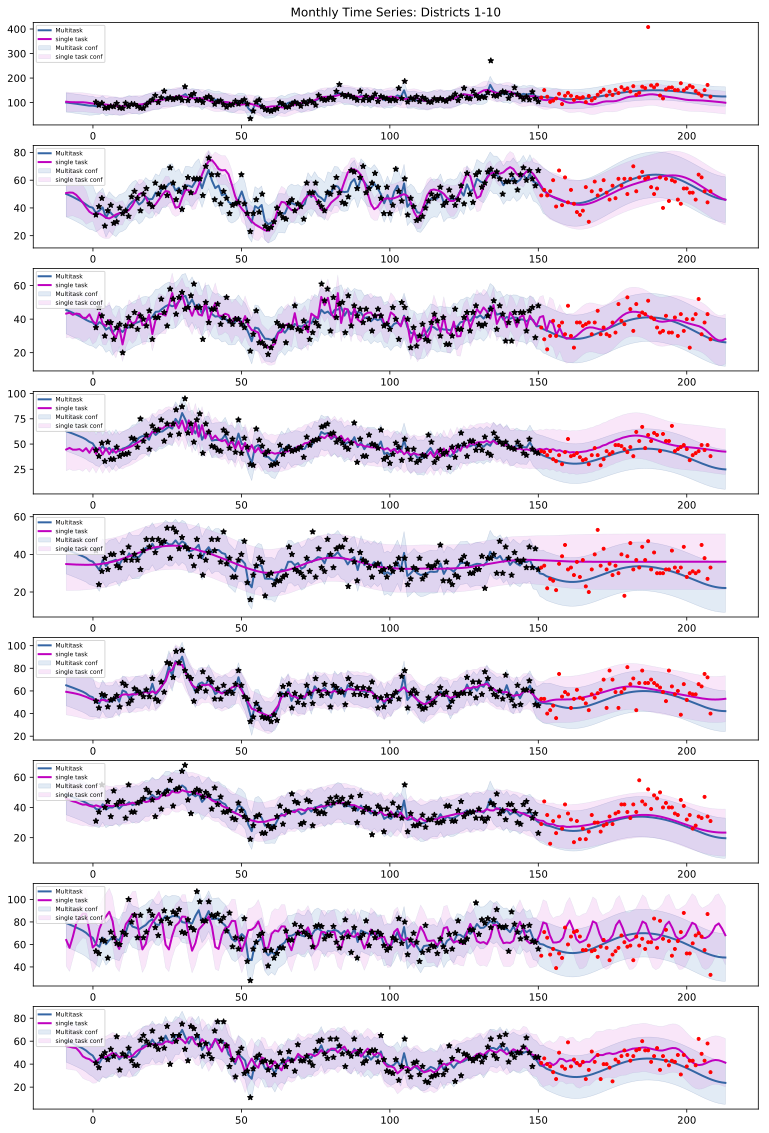

In [50]:
fig = pb.figure(figsize=(13,20))
ax1 = fig.add_subplot(911)
ax2 = fig.add_subplot(912)
ax3 = fig.add_subplot(913)
ax4 = fig.add_subplot(914)
ax5 = fig.add_subplot(915)
ax6 = fig.add_subplot(916)
ax7 = fig.add_subplot(917)
ax8 = fig.add_subplot(918)
ax9 = fig.add_subplot(919)
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
ax1.set_title("Monthly Time Series: Districts 1-10")

for i in range(9):
    limits = (min(model1.trainx[i][:,0])-10, max(model1.testx[i][:,0])+5)
    m1.plot_mean(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask")
    m1.plot_confidence(plot_limits=limits,fixed_inputs=[(1,i)],ax=ax[i], label="Multitask conf")
    
    m_list[i].plot_mean(ax=ax[i], color="m",plot_limits=limits, label="single task")
    m_list[i].plot_confidence(ax=ax[i], color="m",plot_limits=limits, alpha=0.1, label="single task conf")
#     ax[i].plot(X_list[i], Y_list[i], 'k*', label="observed samples")
    ax[i].plot(model1.trainx[i], model1.trainy[i],'k*', alpha=0.8)
    ax[i].plot(model1.testx[i], model1.testy[i],'r.')
    ax[i].legend(loc=2, prop={'size': 6})